# Convolutional Neural Networks 

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

No GPU was detected. CNNs can be very slow without a GPU.


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## The Architecture of the Visual Cortex


* Many neurons in the visual cortex have a small **local receptive field,** meaning they **react only to visual stimuli located in a limited region of the visual field** 

* The receptive fields of different neurons may overlap, and together they tile the whole visual field

* Moreover, some neurons react only to images of horizontal lines. **Some neurons have larger receptive fields,** and they react to more complex patterns that are combinations of the **lower-level patterns**

* **The higher level neurons are based on the outputs of neighboring lower-level neurons** (notice that each neuron is connected only to a few neurons from the previous layer)

* This powerful architecture is able to detect all sorts of complex patterns in any area of the visual field



<p align='center'>
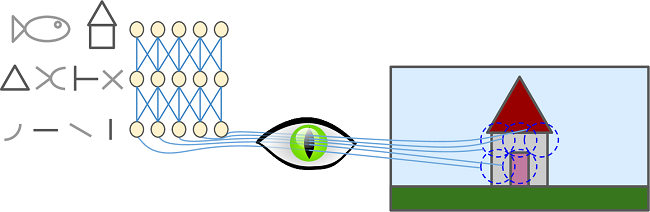
</p>

* Biological neurons in the visual cortex respond to specific patterns in small regions of the visual field called receptive fields; 
* as the visual signal makes its way through consecutive brain modules, neurons respond to more complex patterns in larger receptive fields

## 1. Convolutional Layers

* **neurons in the first convolutional layer are not connected to every single pixel in the input image, but only to pixels in their receptive fields** 

* In turn, **each neuron in the second convolutional layer is connected only to neurons located within a small rectangle in the first layer**

* This architecture allows the network to **concentrate on small low-level features in the first hidden layer, then assemble them into larger higher-level features in the next hidden layer,** and so on

<p align='center'>
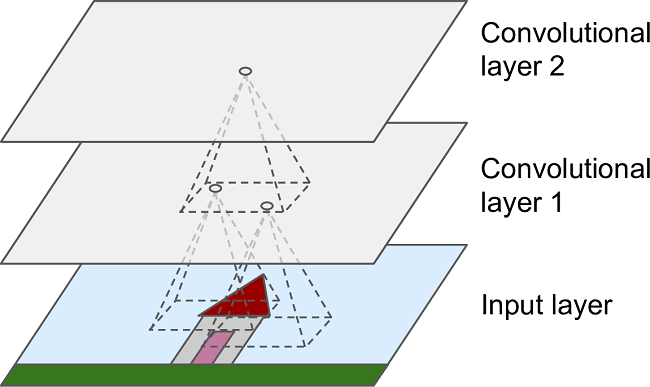
</p>


### Option 1: Same size as the previous layer

* A neuron located in row $i$, column $j$ of a given layer is connected to the outputs of the neurons in the previous layer located in rows $i$ to $i + f_h - 1$, columns $j$ to $j + f_w - 1$, where $f_h$ and $f_w$ are the height and width of the receptive field 

* **In order for a layer to have the same height and width as the previous layer, it is common to add zeros around the inputs, as shown in the diagram.** This is called **zero padding**

<p align='center'>
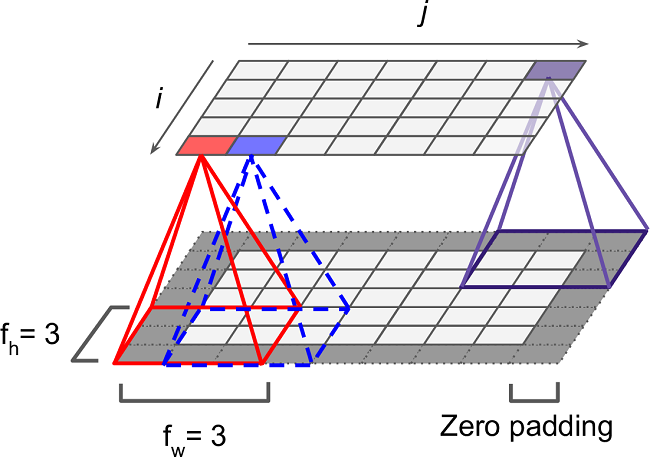
</p>
<center><b>Connections between layers and zero padding</b></center>

### Option 2: Smaller size than the previous layer

* It is also **possible to connect a large input layer to a much smaller layer by spacing out the receptive fields,**  This dramatically **reduces** the model’s **computational complexity**

* The **shift** from one receptive field to the next is called the **stride**

* In the diagram, a $5 \times 7$ input layer (plus zero padding) is connected to a $3 \times 4$ layer, using $3 \times 3$ receptive fields and a stride of 2

* A neuron located in row $i$, column $j$ in the upper layer is connected to the outputs of the neurons in the previous layer located in rows $i \times s_h$ to $i \times s_h + f_h - 1$, columns $j \times s_w$ to $j \times s_w + f_w - 1$, where $s_h$ and $s_w$ are the vertical and horizontal strides

<p align='center'>
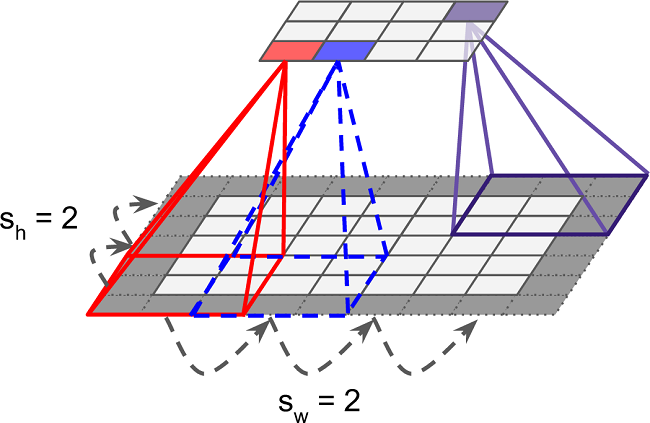
</p>
<center><b>Reducing dimensionality using a stride of 2</b></center>

## Filters

***A simple example of filters:***

* **A neuron’s weights can be represented as a small image the size of the receptive field**. For example, the below shows two possible sets of weights, called **filters (or convolution kernels)**

    * The first one is represented as a black square with a vertical white line in the middle (it is a $7 \times 7$ matrix full of 0s except for the central column, which is full of 1s);
    * The second filter is a black square with a horizontal white line in the middle. Once again, neurons using these weights will ignore everything in their receptive field except for the central horizontal line

* **Neurons using these weights will ignore everything in their receptive field except for the central vertical line** 
    * since all inputs will get multiplied by 0, except for the ones located in the central vertical line

***The results:***

* **the vertical white lines get enhanced while the rest gets blurred**, if all neurons in a layer use the same vertical line filter (and the same bias term)

* **horizontal white lines get enhanced while the rest is blurred out** if all neurons use the same **horizontal line filter;**


***Notes:***

* Thus, **a layer full of neurons using the same filter outputs a feature map,** which **highlights the areas in an image that activate the filter the most**

* **during training the convolutional layer will automatically learn the most useful filters for its task,** 

* and the layers above will **learn to combine them into more complex patterns**






<p align='center'>
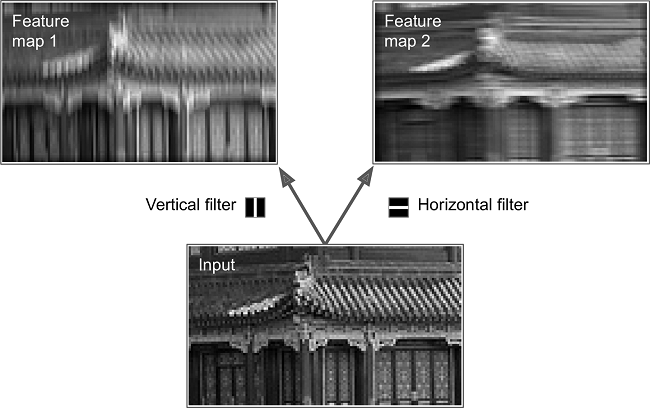
</p>
<center><b>Applying two different filters to get two feature maps</b></center>

## Stacking Multiple Feature Maps

#### **A convolutional layer simultaneously applies multiple trainable filters to its inputs,** making it capable of detecting multiple features anywhere in its inputs

* In reality a convolutional layer has multiple filters (you decide how many) and outputs one feature map per filter, so it is **more accurately represented in 3D** 

* **It has one neuron per pixel in each feature map, and all neurons within a given feature map share the same parameters**(i.e., the same weights and bias term)

* Neurons in different feature maps use different parameters. A neuron’s receptive field is the same as described earlier, but it extends across all the previous layers’ feature maps

* **Input images are also composed of multiple sublayers: one per color channel.** There are typically three: red, green, and blue (RGB). 
* **Grayscale images have just one channel,** but some images may have much more—for example, satellite images that capture extra light frequencies (such as infrared)

<p align='center'>
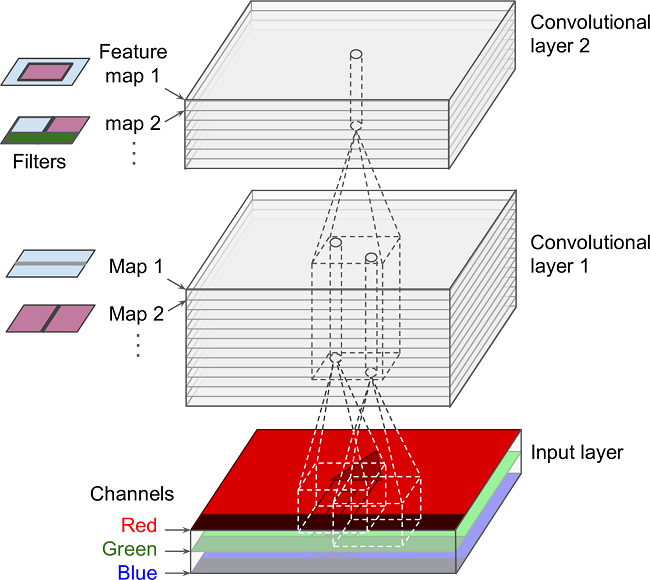
</p>


<center><b>Convolutional layers with multiple feature maps, and images with three color channels</b></center>

* Note that **all neurons located in the same row i and column j but in different feature maps are connected to the outputs of the exact same neurons in the previous layer**

* The equation summarizes the preceding explanations in one big mathematical equation: it shows how to compute the output of a given neuron in a convolutional layer

* **All it does is calculate the weighted sum of all the inputs, plus the bias term**

Computing the output of a neuron in a convolutional layer

<p align='center'>
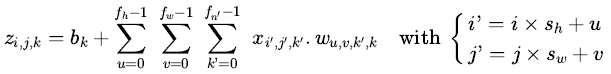
</p>

In this equation:

* $z_{i,j,k}$ is the output of the neuron located in row $i$, column $j$ in feature map $k$ of the convolutional layer (layer $l$)

* As explained earlier, $s_h$ and $s_w$ are the vertical and horizontal strides, $f_h$ and $f_w$ are the height and width of the receptive field, and $f_{n'}$ is the number of feature maps in the previous layer (layrer $l - 1$)

* $x_{i', j', k'}$ is the output of the neuron located in layer $l - 1$, row $i'$, column $j'$, feature map $k'$ (or channel $k′$ if the previous layer is the input layer)

* $b_k$ is the bias term for feature map $k$ (in layer $l$). You can think of it as a knob that tweaks the overall brightness of the feature map k 

* $w_{u, v, k', k}$ is the connection weight between any neuron in feature map $k$ of the layer $l$ and its input located at row $u$, column $v$ (relative to the neuron’s receptive field), and feature map $k′$

#### Example: A 2D Convolution with a 3x3 kernel applied to an 3 channel RGB input of size 5x5 to give output of 3x3.

* In each channel, the Input * Kernel is using element-wise multiplication, then sum all elements in the result of multiplication
* next step, use the intermediate outputs do element-wise addition



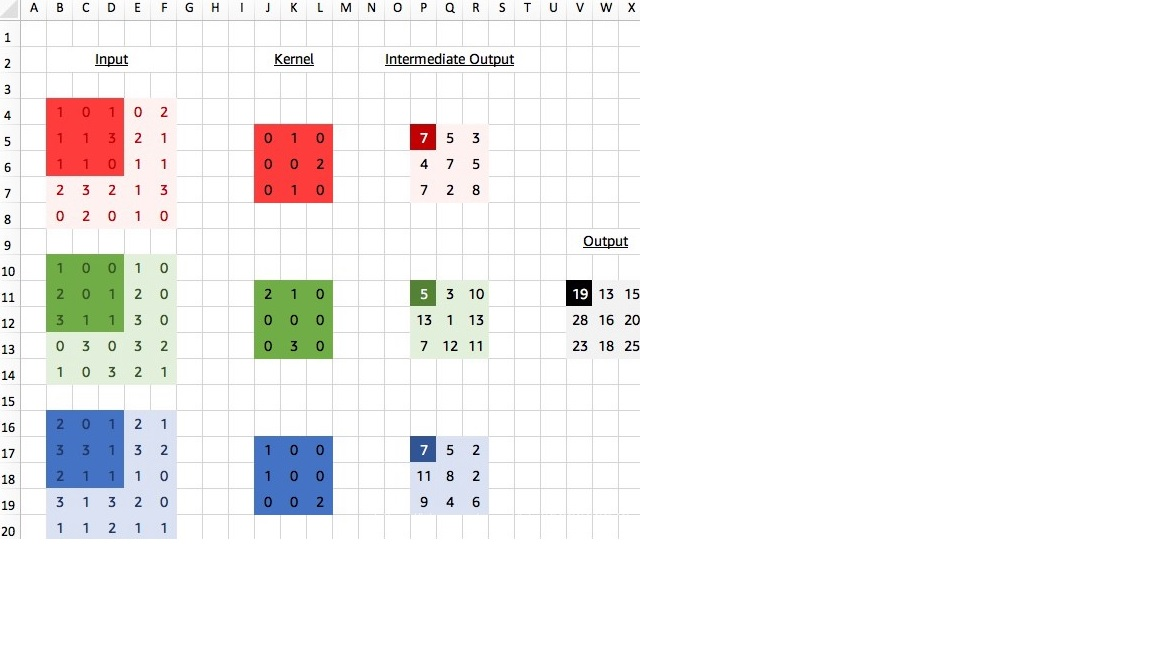

## TensorFlow Implementation

* In TensorFlow, **each input image is typically represented as a 3D tensor of shape [height, width, channels]**

* A **mini-batch** is represented as a **4D tensor** of shape **[mini-batch size, height, width, channels]**

* The **weights** of a convolutional layer are represented as a **4D tensor of shape $[f_h , f_w , f_{n'} , f_n ]$**

* The **bias** terms of a convolutional layer are simply represented as a **1D tensor of shape $[f_n]$**


***Notes***

$f_h , f_w$ are
the height and width of the receptive field 

$f_{n'}$ is the number of feature maps
in the previous layer

$f_{n}$ is the number of feature maps.

### A simple example: 

* **loads two sample images** 
* **creates two filters and applies them to both images** 
* finally it displays one of the resulting feature maps:

In [3]:
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

* Load sample images

* The pixel intensity for each color channel is represented as a byte from 0 to 255, so we scale these features simply by dividing by 255, to get floats ranging from 0 to 1

In [4]:
china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape
images.shape

(2, 427, 640, 3)

* Create two 7 × 7 filters (one with a vertical white line in the middle, and the other with a horizontal white line in the middle)

* In this example we manually defined the filters, but in a real CNN you would normally define filters as trainable variables so the neural net can learn which filters work best

In [5]:
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line

print(filters[:, :, :, 0])
print(filters[:, :, :, 1])

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [1. 1. 1.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [1. 1. 1.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [1. 1. 1.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [1. 1. 1.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [1. 1. 1.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [1. 1. 1.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [1. 1. 1.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1.

* We apply them to both images using the tf.nn.conv2d() function, which is part
of TensorFlow’s low-level Deep Learning API. In this example, we use zero padding
(padding="SAME") and a stride of 1.

In [6]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME')
outputs.shape

TensorShape([2, 427, 640, 2])

* displays one of the resulting feature maps

Text(0.5, 1.0, 'Horizontal Line')

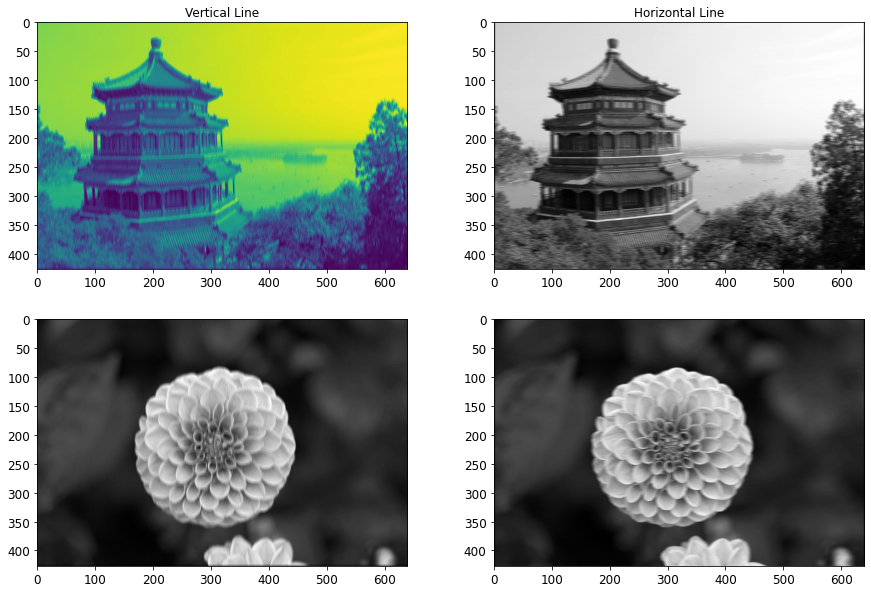

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].imshow(outputs[0, :, :, 0])
# axs[0, 0].imshow(outputs[0, :, :, 0], cmap='gray')
axs[0, 1].imshow(outputs[0, :, :, 1], cmap='gray') # plot 1st image's 2nd feature map
axs[1, 0].imshow(outputs[1, :, :, 0], cmap='gray')
axs[1, 1].imshow(outputs[1, :, :, 1], cmap='gray')
axs[0, 0].set_title('Vertical Line')
axs[0, 1].set_title('Horizontal Line')

#### Notes on ```tf.nn.conv2d()``` in TensorFlow:

* https://www.tensorflow.org/api_docs/python/tf/nn/conv2d

* images is the input mini-batch (a 4D tensor, as explained earlier)

* filters is the set of filters to apply (also a 4D tensor)

* strides is equal to 1, but it could also be a 1D array with four elements, where the two central elements are the vertical and horizontal strides ($s_h$ and $s_w$). The first and last elements must currently be equal to 1. They may one day be used to specify a batch stride (to skip some instances) and a channel stride (to skip some of the previous layer’s feature maps or channels)

* **padding must be either "same" or "valid":**

  * If set to **"same",** the convolutional layer **uses zero padding if necessary.** The **output size** is set to the **number of input neurons divided by the stride, rounded up.** For example, if the **input size is 13 and the stride is 5** , then the **output size is 3 (i.e., 13 / 5 = 2.6, rounded up to 3).** Then **zeros are added as evenly as possible around the inputs,** as needed. **When strides=1, the layer’s outputs will have the same spatial dimensions (width and height) as its inputs,** hence the name same

  * If set to **"valid",** the convolutional layer **does not use zero padding and may ignore some rows and columns at the bottom and right of the input image,** depending on the stride, as shown below. This means that **every neuron’s receptive field lies strictly within valid positions inside the input** (it does not go out of bounds), hence the name valid

<p align='center'>
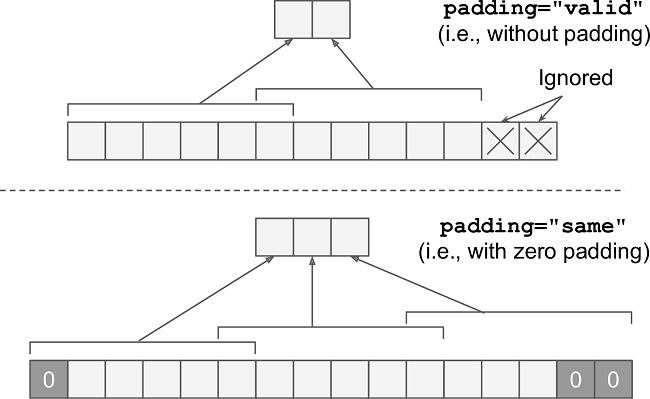
</p>
<center><b>Padding="same” or “valid” (with input width 13, filter width 6, stride 5) </b></center>

#### How to define filters as trainable variables in Keras?

* https://keras.io/api/layers/convolution_layers/convolution2d/
* use the **keras.layers.Conv2D** layer
* creates a Conv2D layer with **32 filters, each 3 × 3,** using a **stride of 1** (both horizontally and vertically) and **"same" padding,** and applying the **ReLU activation** function to its outputs

In [8]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding='same', activation='relu')

***Notes***

* **you must choose the number of filters, their height and width, the strides, and the padding type**

* you can use **cross-validation** to find the right hyperparameter values, but this is very time-consuming

## Memory Requirements

Another problem with CNNs is that the **convolutional layers require a huge amount of RAM**

This is especially true **during training,** because the **reverse pass of backpropagation requires all the intermediate values computed during the forward pass**

For example, consider a convolutional layer with **5 × 5 filters, outputting 200 feature maps of size 150 × 100, with stride 1 and "same" padding**  

If the input is a **150 × 100 RGB image (three channels),** then the **number of parameters is (5 × 5 × 3 + 1) × 200 = 15,200** (the + 1 corresponds to the bias terms), which is fairly small compared to a fully connected layer

However, **each of the 200 feature maps contains 150 × 100 neurons, and each of these neurons needs to compute a weighted sum of its 5 × 5 × 3 = 75 inputs:** that’s a total of **225 million float multiplications.** Not as bad as a fully connected layer, but still quite computationally intensive

Moreover, if the feature maps are represented using **32-bit floats,** then the convolutional layer’s output will occupy **200 × 150 × 100 × 32 = 96 million bits (12 MB) of RAM.** And that’s just for one instance—**if a training batch contains 100 instances, then this layer will use up 1.2 GB of RAM**

**During inference** (i.e., when making a prediction for a new instance) the RAM occupied by one layer can be released as soon as the next layer has been computed, so you **only need as much RAM as required by two consecutive layers**

But **during training** everything computed during the forward pass needs to be preserved for the reverse pass, so the amount of **RAM needed is (at least) the total amount of RAM required by all layers**



# 2. Pooling Layers

* A pooling layer is to **subsample** (i.e., shrink) the **input image** in order to **reduce the computational load, the memory usage, and the number of parameters** (thereby limiting the risk of overfitting)

* Just like in convolutional layers, **each neuron in a pooling layer is connected to the outputs of a limited number of neurons in the previous layer, located within a small rectangular receptive field**

* **You must define its size, the stride, and the padding type,** just like before

* However, **a pooling neuron has no weights;** all it does is **aggregate the inputs** using an aggregation function such as the max or mean. 


#### Example: 

* A **max pooling layer,** which is the most common type of pooling layer

* 2 × 2 pooling kernel, with a stride of 2 and no padding. **Only the max input value in each receptive field makes it to the next layer, while the other inputs are dropped**


<p align='center'>
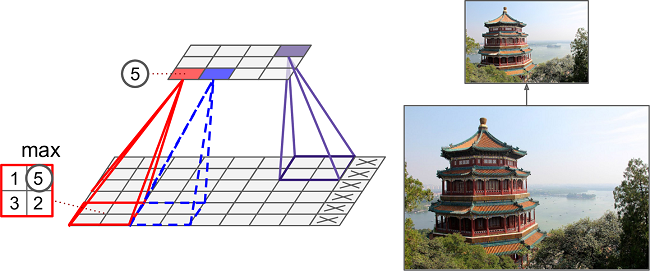
</p>
<center><b>Max pooling layer (2 × 2 pooling kernel, stride 2, no padding)</b></center>

#### Translation invariance

* A **max pooling layer** also introduces some level of **invariance to small translations,** as shown below

* Here we assume that the **bright pixels have a lower value than dark pixels,** and we consider three images (A, B, C) going through a max pooling layer with a **2 × 2 kernel and stride 2**

* Images B and C are the same as image A, but shifted by one and two pixels to the right. As you can see, the outputs of the **max pooling layer for images A and B are identical.** This is what translation invariance means. For image C, the output is different: it is shifted one pixel to the right (but there is still 75% invariance)

* Moreover, **max pooling offers** a small amount of **rotational invariance** and a slight **scale invariance**. Such invariance (even if it is limited) can be **useful in cases where the prediction should not depend on these details,** such as in **classification tasks**

***Notes:***

* By inserting a max pooling layer every few layers in a CNN, it is possible to get some level of translation invariance at a larger scale





<p align='center'>
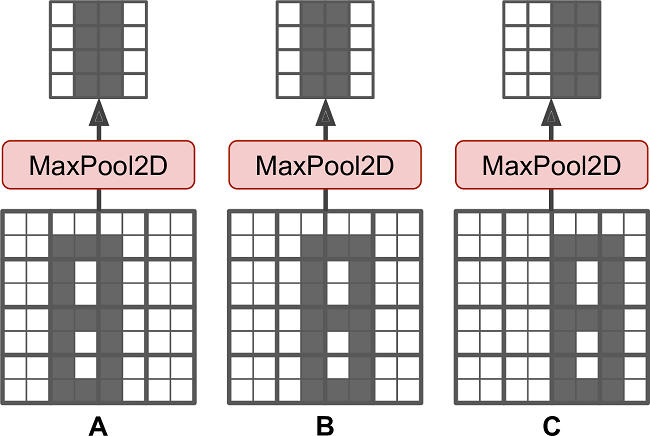
</p>
<center><b>Invariance to small translations</b></center>

#### Downsides of translation invariance

* It is obviously **very destructive:** even **with a tiny 2 x 2 kernel and a stride of 2, the output will be two times smaller in both directions** (so its area will be four times smaller), simply dropping 75% of the input values

* **And in some applications, invariance is not desirable.** Take **semantic segmentation** (the task of classifying each pixel in an image according to the object that pixel belongs to): obviously, if the input image is translated by one pixel to the right, the output should also be translated by one pixel to the right. **The goal in this case is equivariance, not invariance: a small change to the inputs should lead to a corresponding small change in the output**

## TensorFlow Implementation

The following code creates a **max pooling layer using a 2 × 2 kernel**

**The strides default to the kernel size,** so this layer will use a stride of 2 (both horizontally and vertically). By default, it uses padding (i.e., no "valid" padding at all):

In [9]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

#### Average pooling vs Max pooling

* To create an **average pooling layer,** just use **AvgPool2D** instead of  MaxPool2D, it computes the mean rather than the max

* https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D

* https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D

* max pooling layers generally perform better

* **computing the mean generally loses less information than computing the max.** But on the other hand, **max pooling preserves only the strongest features, getting rid of all the meaningless ones,** so the next layers get a **cleaner signal** to work with. 

* Moreover, **max pooling offers stronger translation invariance than average pooling, and it requires slightly less compute**

Note that max pooling and average pooling **can be performed along the depth dimension rather than the spatial dimensions,** although this is not as common. This can allow the CNN to learn to be **invariant to various features**

**For example, it could learn multiple filters, each detecting a different rotation of the same pattern** (such as hand-written digits), and the **depthwise max pooling layer** would ensure that the **output is the same regardless of the rotation.** The CNN could similarly learn to be **invariant** to anything else: **thickness, brightness, skew, color,** and so on

<p align='center'>
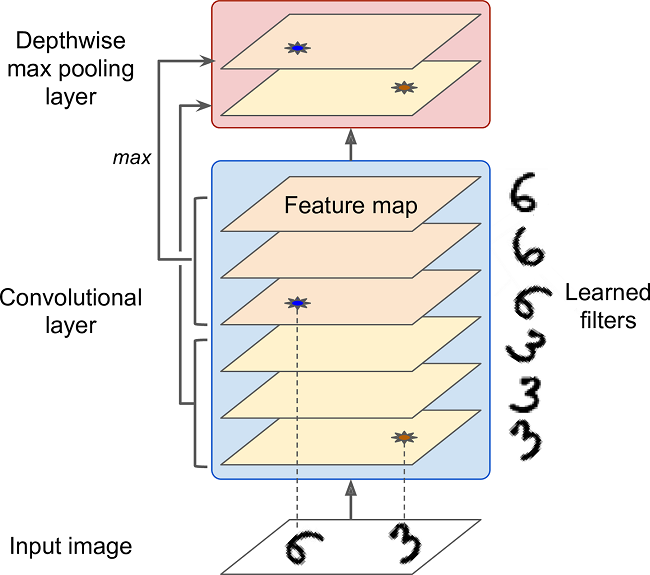
</p>
<center><b>Depthwise max pooling can help the CNN learn any invariance</b></center>

#### Implement equivalent max pooling in Tensorflow as Lambda layer


* https://www.tensorflow.org/api_docs/python/tf/nn/max_pool
* use the **tf.nn.max_pool()** function, and **specify the kernel size and strides as 4-tuples (i.e., tuples of size 4)**

* The **first three values of each should be 1:** this indicates that the **kernel size and stride along the batch, height, and width dimensions should be 1**

* The **last value should be whatever kernel size and stride** you want along the depth dimension—for example, 3 (this **must be a divisor of the input depth;** it will not work if the previous layer outputs 20 feature maps, since 20 is not a multiple of 3):

In [10]:
#output = tf.nn.max_pool(images,
#                        ksize=(1, 1, 1, 3),
#                        strides=(1, 1, 1, 3),
#                        padding='VALID')

* ***If you want to include this as a layer in your Keras models, wrap it in a Lambda layer (or create a custom Keras layer):***

In [11]:
depth_pool = keras.layers.Lambda(
    lambda X: tf.nn.max_pool(X, ksize=(1, 1, 1, 3),
                        strides=(1, 1, 1, 3),
                        padding='VALID'))

#### global average pooling layer

* compute the **mean of each entire feature map** i.e., **outputs a single number per feature map and per instance**

* **extremely destructive**, it **can be useful as the output layer**. To create such a layer, simply use the **keras.layers.GlobalAvgPool2D** class: 



In [12]:
global_avg_pool = keras.layers.GlobalAvgPool2D()

* It’s equivalent to this simple layer, which computes the mean over Lambda the spatial dimensions (height and width):

In [13]:
global_avg_pool = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))

# CNN Architectures

* **stack a few convolutional layers** (each one generally **followed by a ReLU layer**), then a **pooling layer,** then another few convolutional layers (+ReLU), then another pooling layer, and so on

* The **image gets smaller and smaller** as it progresses through the network, but it also typically gets **deeper and deeper (i.e., with more feature maps)** 

* **At the top of the stack, a regular feedforward neural network is added, composed of a few fully connected layers** (+ReLUs)

* Then the **final layer outputs the prediction** (e.g., a softmax layer that outputs estimated class probabilities)

<p align='center'>
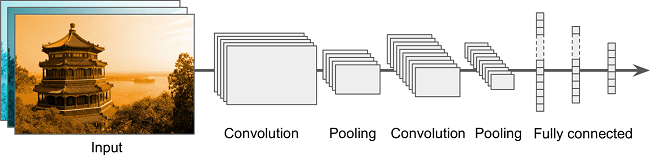
</p>
<center><b>Typical CNN architecture</b></center>

#### Tips:

* **use small convolution kernels**. **instead of using a convolutional layer with a 5 x 5 kernel, stack two layers with 3 x 3 kernels:** it will use **fewer parameters** and require **fewer computations,** and it will usually **perform better** 

* The **first convolutional layer: it can typically have a large kernel (e.g., 5 x 5),** usually with a **stride of 2 or more:** this will **reduce the spatial dimension of the image without losing too much information,** and since the input image only has three channels in general, it will not be too costly

**Here is how you can implement a simple CNN to tackle the Fashion MNIST dataset:**

In [14]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [15]:
X_train.shape

(55000, 28, 28)

In [16]:
X_valid.shape

(5000, 28, 28)

In [17]:
X_test.shape

(10000, 28, 28)

* get each feature's average

In [18]:
X_mean = X_train.mean(axis=0, keepdims=True)

In [19]:
X_mean.shape

(1, 28, 28)

In [20]:
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

* Add a dimension for channels => (batch_size, height, width, channels)

In [21]:
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [22]:
X_train.shape

(55000, 28, 28, 1)

* Now we build the model

In [23]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation='relu', padding='same',
                        input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

Let’s go through this model:

* The first layer uses **64 fairly large filters (7 x 7)** but **no stride** because the **input images are not very large.** It also sets input_shape=[28, 28, 1], because the images are 28 x 28 pixels, with a single color channel (i.e., grayscale)

* Next we have a max pooling layer which uses a **pool size of 2,** so it **divides each spatial dimension by a factor of 2**

* Then we **repeat the same structure twice: two convolutional layers followed by a max pooling layer.** For larger images, we could repeat this structure several more times (the number of repetitions is a hyperparameter you can tune)

* Note that the **number of filters grows as we climb up the CNN toward the output layer** (it is initially 64, then 128, then 256): it makes sense for it to grow, **since the number of low-level features is often fairly low (e.g., small circles, horizontal lines), but there are many different ways to combine them into higher-level features.** It is a **common practice to double the number of filters after each pooling layer:** since a **pooling layer divides each spatial dimension by a factor of 2, we can afford to double the number of feature maps** in the next layer without fear of exploding the number of parameters, memory usage, or computational load

* Next is the **fully connected network, composed of two hidden dense layers and a dense output layer.** Note that **we must flatten its inputs,** since a **dense network expects a 1D array of features for each instance.** We also add two **dropout layers,** with a dropout rate of 50% each, to **reduce overfitting**



In [24]:
model.compile( loss="sparse_categorical_crossentropy",
               optimizer='nadam',
               metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid)) 
# I use epochs=1 for fast demo. It takes about 5 mins on my laptop without GPU enabled. You can try epochs=10. It will take a while.

score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)
print(score)

313/313 [==============================] - 18s 57ms/step - loss: 0.3845 - accuracy: 0.8648
[0.3844967484474182, 0.864799976348877]


## The recent advances in CNN architecture

## LeNet-5

* **widely used for handwritten digit recognition (MNIST).** 

**LeNet-5 architecture**

<p align='center'>
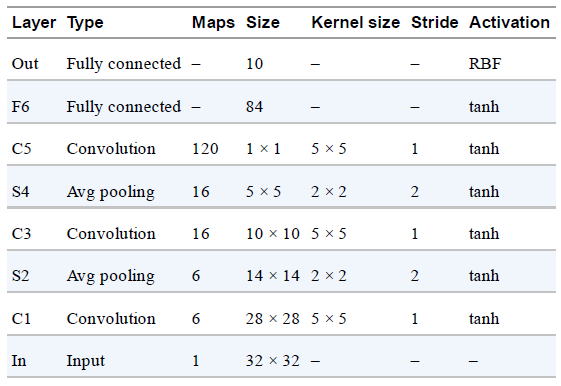
</p>

There are a few extra details to be noted:

* MNIST images are 28 x 28 pixels, but they are **zero-padded to 32 x 32 pixels** and normalized before being fed to the network. The **rest of the network does not use any padding,** which is why the **size keeps shrinking** as the image progresses through the network

* The average pooling layers are slightly more complex than usual: **each neuron computes the mean of its inputs,** then **multiplies the result by a learnable coefficient** (one per map) and **adds a learnable bias term** (again, one per map), then finally applies the activation function

* **Most neurons in C3 maps are connected to neurons in only three or four S2 maps (instead of all six S2 maps)**. 

* The **output layer** is a bit special: **instead of computing the matrix multiplication of the inputs and the weight vector, each neuron outputs the square of the Euclidian distance between its input vector and its weight vector.** 

* **Each output measures how much the image belongs to a particular digit class.** The **cross-entropy cost function** is now preferred, as it **penalizes bad predictions much more,** producing **larger gradients and converging faster**

Yann LeCun’s [website](http://yann.lecun.com/exdb/lenet/index.html) features great demos of LeNet-5 classifying digits

<img src="http://yann.lecun.com/exdb/lenet/gifs/asamples.gif" width="750" align="center">

## AlexNet

* It is similar to LeNet-5, only much larger and deeper

* it was the first to **stack convolutional layers directly on top of one another, instead of stacking a pooling layer on top of each convolutional layer**



**AlexNet architecture**

<p align='center'>
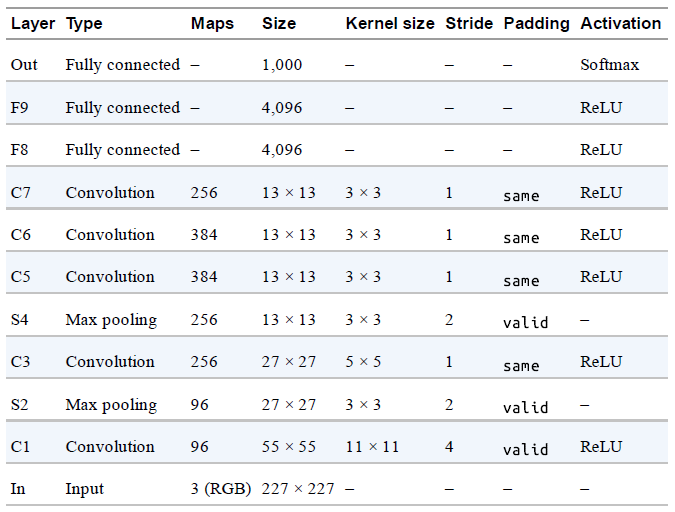
</p>

**The improvements**

* reduce overfitting
    * **dropout** with a 50% dropout rate during training to the outputs of layers **F8 and F9**

    * **data augmentation** by **randomly shifting the training images by various offsets, flipping them horizontally, and changing the lighting conditions**
    
    * **Data augmentation** artificially increases the size of the training set by **generating many realistic variants of each training instance.** This reduces overfitting, making this a regularization technique    
    

<p align='center'>
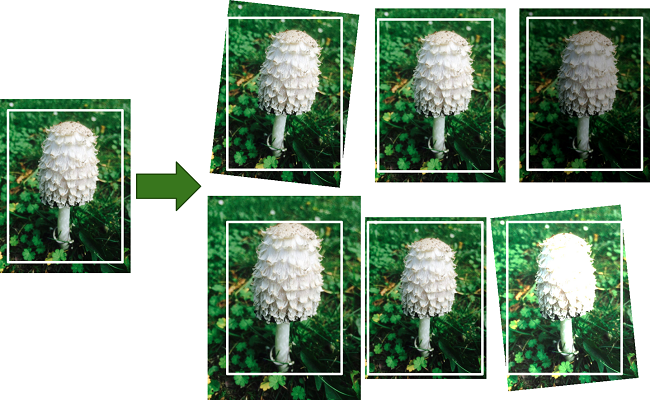
</p>
<center><b>Generating new training instances from existing ones</b></center>

    
    
 
* Local response normalization (LRN)

    * **normalization** immediately **after the ReLU step of layers C1 and C3,**: the most strongly activated neurons inhibit other neurons located at the same position in neighboring feature maps
    
    * This **encourages different feature maps to specialize,** pushing them apart and **forcing them to explore a wider range of features,** ultimately **improving generalization**

**Local response normalization (LRN)**

<p align='center'>
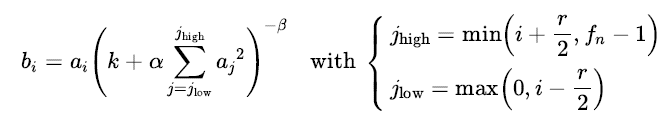
</p>

In this equation:

* **$b_i$ is the normalized output of the neuron** located in **feature map $i$,** at some **row $u$** and **column $v$** (note that in this equation we consider only neurons located at this row and column, so u and v are not shown)

* **$a_i$ is the activation of that neuron after the ReLU step, but before normalization**

* $k, \alpha, \beta, r$ are hyperparameters. $k$ is called the bias, and r is called the depth radius

* $f_n$ is the number of feature maps

For example, **if $r=2$ and a neuron has a strong activation, it will inhibit
the activation of the neurons located in the feature maps immediately
above and below its own**

In AlexNet, the hyperparameters are set as follows: **$r=2, \alpha=0.00002, \beta=0.75$ and $k=1$**. This step can be implemented using the **tf.nn.local_response_normalization()** function (which you can wrap in a Lambda layer if you want to use it in a Keras model) 


A variant of AlexNet called [ZF Net](https://arxiv.org/abs/1311.2901) was developed by Matthew Zeiler and Rob Fergus and won the 2013 ILSVRC challenge. It is essentially **AlexNet with a few tweaked hyperparameters (number of feature maps, kernel size, stride, etc.)**

## GoogLeNet

* **the network was much deeper than previous CNNs**

* This was made possible by subnetworks called inception modules

* GoogLeNet actually has **10 times fewer parameters than AlexNet** (roughly **6 million instead of 60 million**)

* **The notation “3 x 3 + 1(S)” means that the layer uses a 3 x 3 kernel, stride 1, and "same" padding.** The **input signal is first copied and fed to four different layers.** All convolutional layers use the **ReLU activation function**

***Notes:***

* The **second set of convolutional layers uses different kernel sizes** (1 x 1, 3 x 3, and 5 x 5), allowing them to **capture patterns at different scales**

* **every single layer uses a stride of 1 and "same" padding** (even the max pooling layer), so their **outputs all have the same height and width as their inputs.** 

* This makes it **possible to concatenate all the outputs along the depth dimension** in the final **depth concatenation layer** (i.e., stack the feature maps from all four top convolutional layers)


<p align='center'>
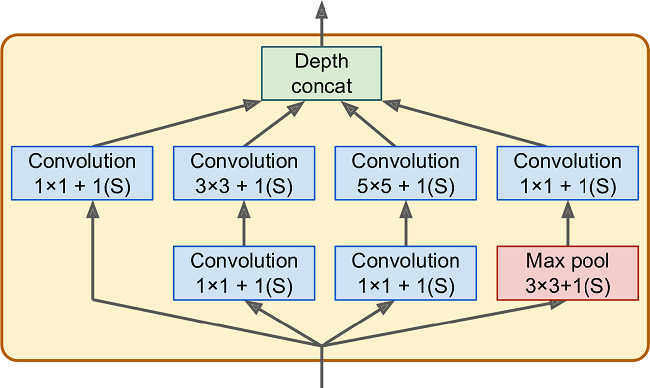
</p>

<center><b>Inception module</b></center>

You may wonder why inception modules have convolutional layers with **1 x 1 kernels.** Surely **these layers cannot capture any features because they look at only one pixel at a time?** In fact, the layers serve three purposes:

* Although they cannot capture spatial patterns, they can **capture patterns along the depth dimension**

* They are configured to **output fewer feature maps than their inputs,** so **they serve as bottleneck layers, meaning they reduce dimensionality.** This cuts the computational cost and the number of parameters, speeding up training and improving generalization

* **Each pair of convolutional layers** ([1 x 1, 3 x 3] and [1 x 1, 5 x 5]) **acts like a single powerful convolutional layer, capable of capturing more complex patterns.** Indeed, instead of sweeping a simple linear classifier across the image (as a single convolutional layer does), **this pair of convolutional layers sweeps a two-layer neural network across the image**

In short, you can think of the whole **inception module** as **a convolutional layer on steroids,** able to output feature maps that capture **complex patterns at various scales**


The architecture is so deep that it has to be represented in three columns, but GoogLeNet is actually one tall stack, including **nine inception modules** (the boxes with the spinning tops)

The **six numbers** in the inception modules represent the **number of feature maps output by each convolutional layer in the module.** Note that all the convolutional layers use the **ReLU** activation function

<p align='center'>
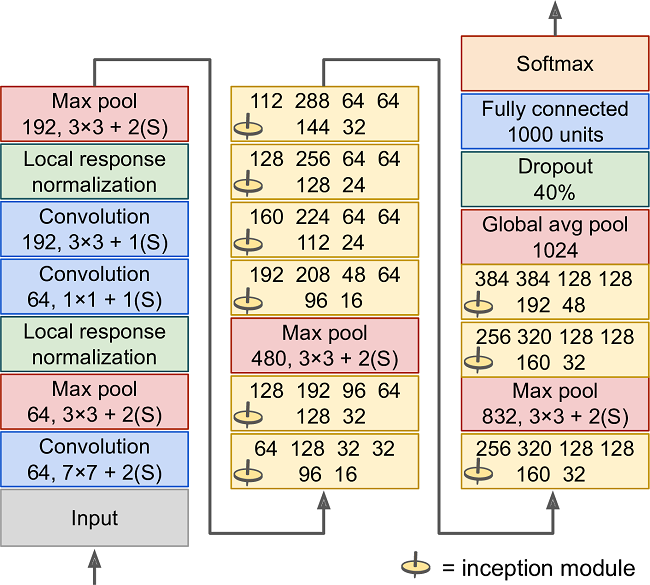
</p>
<center><b>GoogLeNet architecture</b></center>

Let’s go through this network:

* **The first two layers divide the image’s height and width by 4 (so its area is divided by 16), to reduce the computational load.** The **first layer** uses a **large kernel** size so that much of the **information is preserved**

* **Then the local response normalization layer ensures that the previous layers learn a wide variety of features**

* **Two convolutional layers follow, where the first acts like a bottleneck layer.** As explained earlier, you can think of this pair as a single smarter convolutional layer

* Again, a local response normalization layer ensures that the previous layers capture a wide variety of patterns

* Next, a **max pooling layer reduces the image height and width by 2,** again to speed up computations

* Then comes the tall **stack of nine inception modules,** interleaved with a couple **max pooling layers** to **reduce dimensionality** and speed up the net

* Next, the **global average pooling layer outputs the mean of each feature map: this drops any remaining spatial information,** which is fine because there was not much spatial information left at that point. Indeed, GoogLeNet input images are typically expected to be 224 x 224 pixels, so **after 5 max pooling layers, each dividing the height and width by 2, the feature maps are down to 7 x 7.** Moreover, it is a **classification task,** not localization, so it **does not matter where the object is.** **Thanks to the dimensionality reduction brought by this layer, there is no need to have several fully connected layers at the top of the CNN** (like in AlexNet), and this considerably reduces the number of parameters in the network and limits the risk of overfitting

* The last layers are self-explanatory: **dropout for regularization, then a fully connected layer with 1,000 units (since there are 1,000 classes) and a softmax activation function to output estimated class probabilities**





## ResNet

* It used an **extremely deep CNN composed of 152 layers** (other variants had 34, 50, and 101 layers). 
* It confirmed the **general trend: models are getting deeper and deeper, with fewer and fewer parameters**

* The key is to use **skip connections** (also called shortcut connections): **the signal feeding into a layer is also added to the output of a layer located a bit higher up the stack.** 

***The idea: residual learning***

**When training a neural network, the goal is to make it model a target function $h(x)$.** If you add the input x to the output of the network (i.e., you **add a skip connection),** then the network will be forced to model $f(x) = h(x) - x$ rather than $h(x)$. 

<p align='center'>
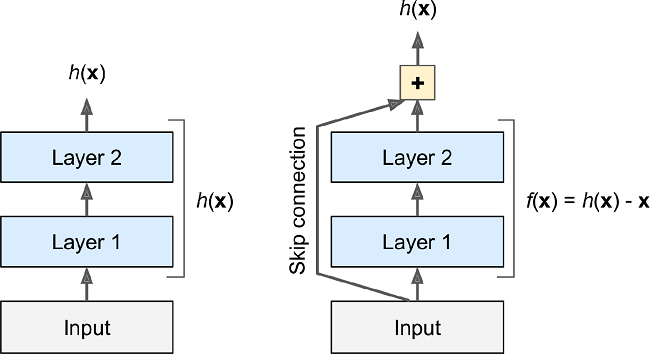
</p>
<center><b>Residual learning</b></center>

***Notes:***

* When you initialize a regular neural network, its weights are close to zero, so the network just outputs values close to zero. 
* **If you add a skip connection, the resulting network just outputs a copy of its inputs; in other words, it initially models the identity function.** * **If the target function is fairly close to the identity function** (which is often the case), this will **speed up training considerably**

***Skip connection helps faster training***

* if you add many skip connections, **the network can start making progress even if several layers have not started learning yet**. 

* **the signal can easily make its way across the whole network.** 
* The **deep residual network** can be seen as a **stack of residual units (RUs),** where each **residual unit** is a **small neural network with a skip connection**

<p align='center'>
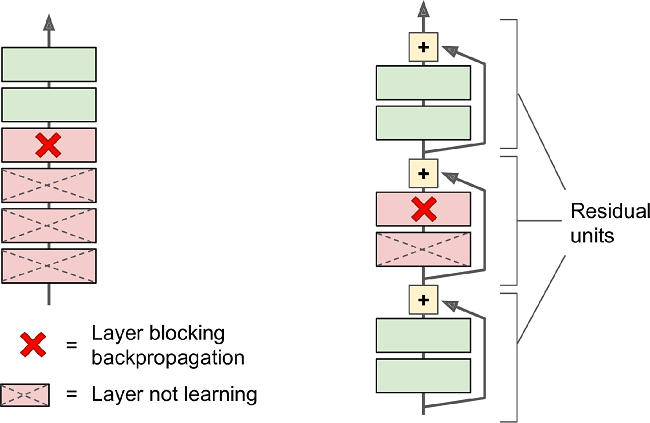
</p>
<center><b>Regular deep neural network (left) and deep residual network (right)</b></center>

#### ResNet’s architecture

* **It starts and ends exactly like GoogLeNet** (except without a dropout layer)
* and in between is just a **very deep stack of simple residual units**

* As shown below, each **residual unit** is composed of **two convolutional layers** (and no pooling layer!), with **Batch Normalization (BN) and ReLU activation,** using **3 × 3 kernels** and preserving spatial dimensions **(stride 1, "same" padding)** 

<p align='center'>
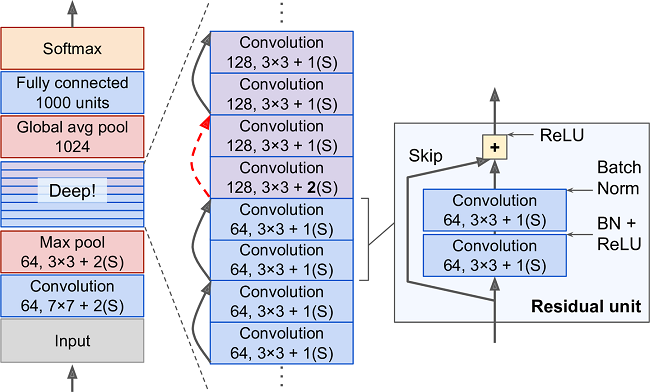
</p>
<center><b>ResNet architecture</b></center>

***A little trick***

* Note that the **number of feature maps is doubled every few residual units,** at the same time as their **height and width are halved** (using a convolutional layer with **stride 2)**

* When this happens, the inputs **cannot be added directly to the outputs of the residual unit** because they **don’t have the same shape** (for example, this problem affects the skip connection represented by the **dashed arrow** )

* To solve this problem, the inputs are passed through a 1 × 1 convolutional layer with stride 2 and the right number of output feature maps


<p align='center'>
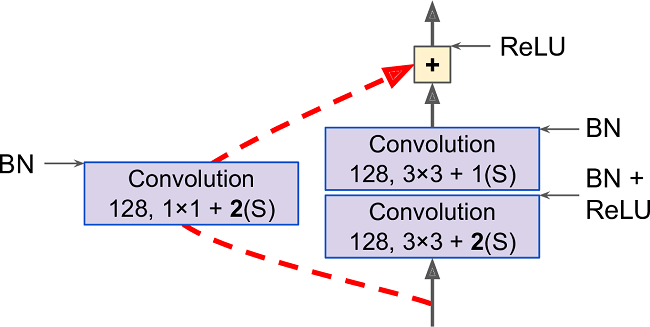
</p>
<center><b>Skip connection when changing feature map size and depth</b></center>

**ResNet-34 is the ResNet with 34 layers** (only counting the convolutional layers and the fully connected layer) containing **3 residual units that output 64 feature maps, 4 RUs with 128 maps, 6 RUs with 256 maps, and 3 RUs with 512 maps**


# Implementing a ResNet-34 CNN Using Keras

**First, let’s create a ResidualUnit layer:**

* the **main layers** are the ones on the **right side of the diagram,** 
* the **skip layers** are the ones on the **left** **(only needed if the stride is greater than 1)**

* the **call() method makes the inputs go through the main layers and the skip layers** (if any), then we **add both outputs and apply the activation function**

In [25]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

**Then build the ResNet-34 using a Sequential model:**

In [26]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 residual_unit (ResidualUnit  (None, 56, 56, 64)       74240     
 )                                                               
                                                      

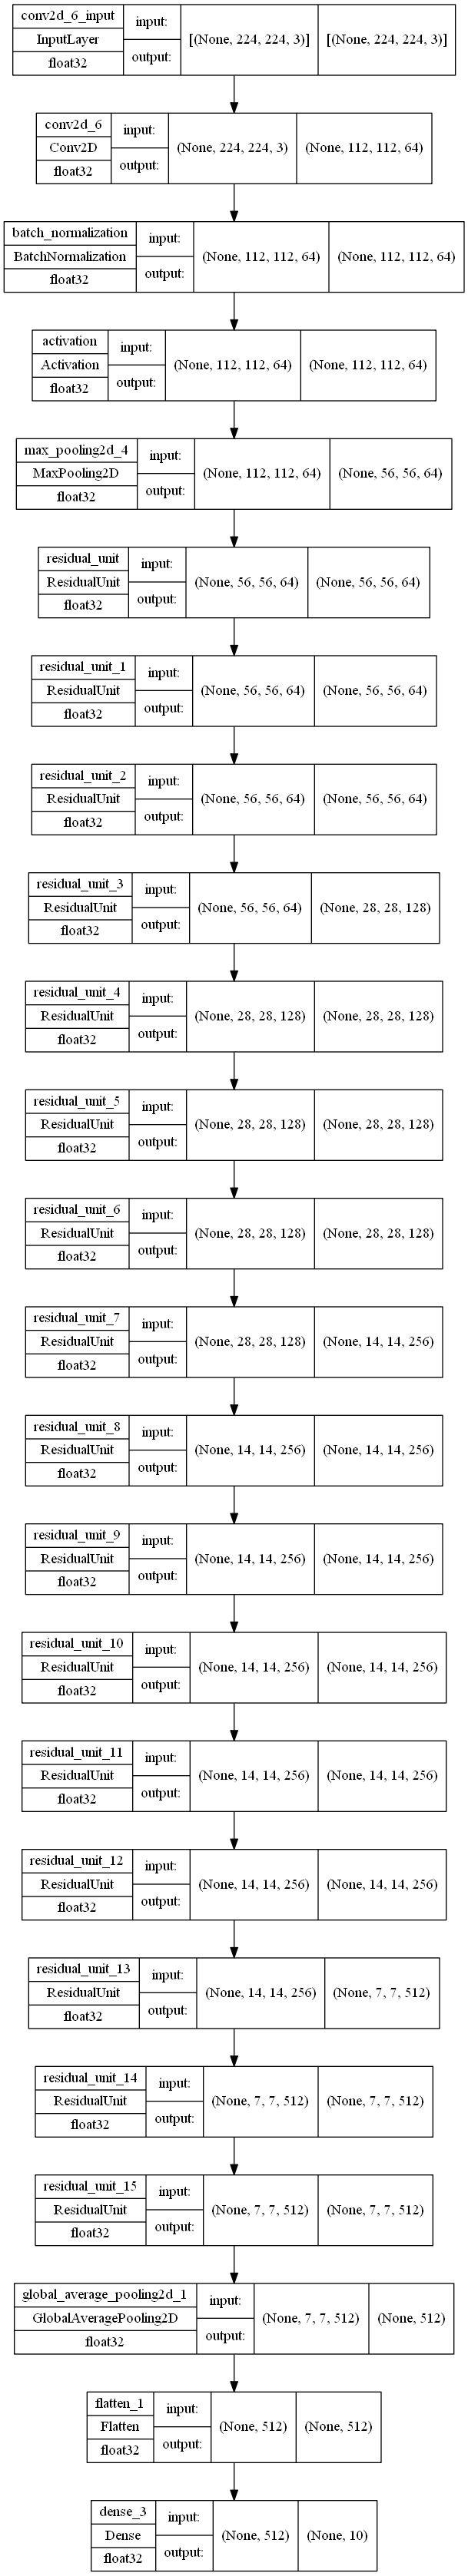

In [28]:
keras.utils.plot_model(model, show_dtype=True, show_shapes=True, 
                       show_layer_names=True)

***Notes***

* the first 3 RUs have 64 filters, then the next 4 RUs have 128 filters, and so on

* then **set the stride to 1 when the number of filters is the same as in the previous RU, or else we set it to 2.** 

* Then we add the ResidualUnit and finally we update prev_filters

# Classification and Localization

* **Localizing** an object in a picture can be expressed as a **regression task,**: to predict a **bounding box** around the object, a common approach is to predict the **horizontal and vertical coordinates of the object’s center,** as well as its **height** and **width**

* This means we have **four numbers to predict.** It does not require much change to the model; 

* we just need to **add a second dense output layer with four units** (typically **on top of the global average pooling layer**), and it can be trained using the **MSE loss:**

In [30]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

Dataset tf_flowers downloaded and prepared to C:\Users\damin\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [31]:
n_classes = info.features["label"].num_classes

In [32]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)

In [33]:
base_model = keras.applications.xception.Xception(weights='imagenet',
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation='softmax')(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
model.compile(loss=['sparse_categorical_crossentropy', 'mse'],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=['accuracy'])

83697664/83683744 [==============================] - 7s 0us/step


**Intersection over Union (IoU):**

* The most common metric for evaluating how well the model can **predict bounding boxes** is the **Intersection over Union (IoU)** 
* the area of **overlap** between the predicted bounding box and the target bounding box, **divided by the area of their union** 

* In tf.keras, it is implemented by the **tf.keras.metrics.MeanIoU** class

<p align='center'>
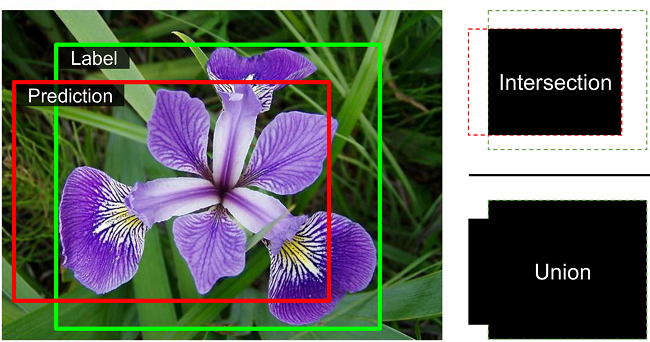
</p>